# Society for Neuroscience Annual Meeting, 2022
# \#8587 Population spike-synchrony contributes to the spectral exponent of aperiodic neural activity
#### M. W. Preston, S. Fei, B. Voytek
## Poster Panel \#4: Simulating surrogate LFPs using empirical spike trains recorded from the primary visual cortex of macaques (Dataset: Kohn & Smith, 2016)

### Set-up

#### Imports

In [1]:
# general imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import TwoSlopeNorm, Normalize
from matplotlib.cm import ScalarMappable

In [2]:
# spike analysis toolboxes

# elephant
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import correlation_coefficient, covariance

# elephant reqs
import neo
import quantities as pq


In [3]:
# voytek lab imports
from neurodsp.spectral import compute_spectrum
from neurodsp.utils import create_times


In [4]:
# project-specific imports
import sys
sys.path.append('C:/users/micha/projects/sfn_2022//scripts')
from utils import comp_exp, spiketimes_to_spiketrains, spikes_to_lfp


#### Settings

In [5]:
# directories
PATH = "C:/Users/micha/projects/sfn_2022"
DIR_FIG = PATH + "/figures"
DIR_DATA = PATH + "/data"

# example suject
SUB = 1

In [6]:
# dataset details
FS = 1000 # sampling frequency
DURATION = 31 # duration of epoch

# analysis settings
F_RANGE = [1,100]

# figure appearance
plt.style.use(PATH + '/stylelib/sfn_2022.mplstyle')
COLORS = ["#7570b3", "#1b9e77", "#d95f02"]

#### Functions

### Main

#### Import dataset

In [7]:
# load spiking data for both subject
temp = np.load(PATH + f'/data/movie_spike_times_{SUB}.npy', allow_pickle=True)
spike_times_natural = temp[1]
spike_times_noise = temp[2]


#### plot spiking data

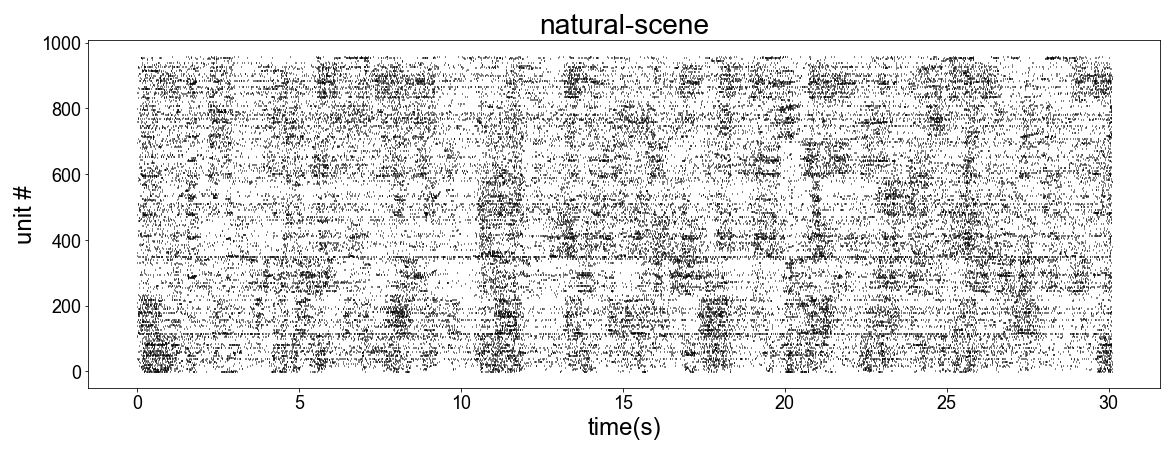

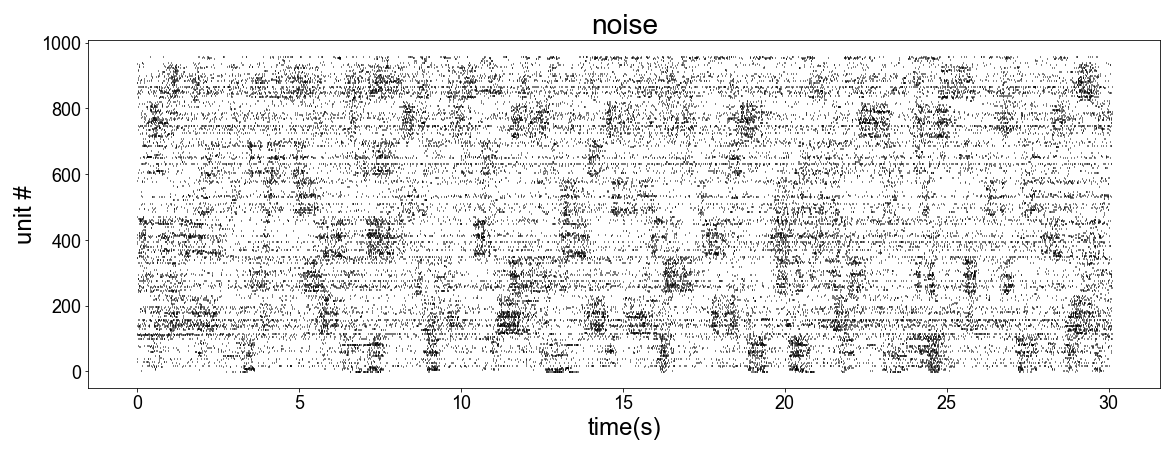

In [8]:
# plot spiking

# settings
n2plot = 1000 # plot first N units only

# init
spike_times_natural_plt = []
spike_times_noise_plt = []

# get spikes times (skip cells without data)
for i_unit in range(n2plot):
    if np.ndim(spike_times_natural[i_unit]) == 0: continue
    if len(spike_times_natural[i_unit]) == 0: continue
    if np.ndim(spike_times_noise[i_unit]) == 0: continue
    if len(spike_times_noise[i_unit]) == 0: continue
    spike_times_natural_plt.append(spike_times_natural[i_unit])
    spike_times_noise_plt.append(spike_times_noise[i_unit])

# plot event plot - natural
fig, ax = plt.subplots(figsize=[16,6])
ax.eventplot(spike_times_natural_plt, color='k', linewidth=1)
ax.set(ylabel='unit #', xlabel='time(s)')
ax.set_title('natural-scene')

# plot event plot - noise
fig, ax = plt.subplots(figsize=[16,6])
ax.eventplot(spike_times_noise_plt, color='k', linewidth=1)
ax.set(ylabel='unit #', xlabel='time(s)')
ax.set_title('noise');


#### compute spiking correlation

In [9]:
# compute correlation/covarience measures

# inti
n_neurons = len(spike_times_natural)
corr_mat = []
cov_mat = []
corr_mu = np.zeros(2)
cov_mu = np.zeros(2)

# loop through conditions
for ii, st in enumerate([spike_times_noise,spike_times_natural]):
    n_units = len(st)
    spike_trains = []
    
    # loop through units
    for i_unit in range(n_units):
        # skip units withou spikes
        if np.ndim(st[i_unit]) == 0: continue
        if len(st[i_unit]) == 0: continue
        # create spike train
        st_i = neo.SpikeTrain(st[i_unit]*pq.s, DURATION*pq.s)
        spike_trains.append(st_i)

    # compute corr
    cov_mat.append(covariance(BinnedSpikeTrain(spike_trains, bin_size=10*pq.ms)))
    cov_mu[ii] = np.mean(cov_mat[ii])
    corr_mat.append(correlation_coefficient(BinnedSpikeTrain(spike_trains, bin_size=10*pq.ms)))
    corr_mu[ii] = np.mean(corr_mat[ii])

c:\Users\micha\anaconda3\envs\sfn_2022\lib\site-packages\elephant\utils.py:291: UserWarning: Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '
c:\Users\micha\anaconda3\envs\sfn_2022\lib\site-packages\elephant\utils.py:291: UserWarning: Correcting 2 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '
c:\Users\micha\anaconda3\envs\sfn_2022\lib\site-packages\elephant\utils.py:291: UserWarning: Correcting 3 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '
c:\Users\micha\anaconda3\envs\sfn_2022\lib\site-packages\elephant\utils.py:291: UserWarning: Correct

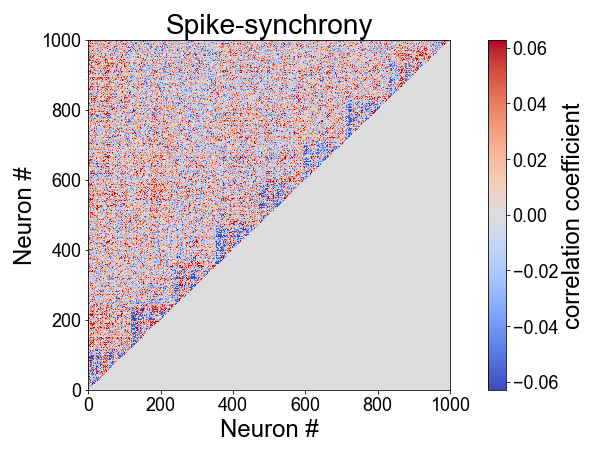

In [10]:
# plot corr

# settings
n2plot = 1000 # plot first N units only

# # combine data for compact plotting
# corr_mat_comb = np.tril(corr_mat[0][:n2plot,:n2plot], -1) + \
#     np.triu(corr_mat[1][:n2plot,:n2plot], 1)

# combine data for compact plotting
corr_mat_comb = np.tril(corr_mat[1][:n2plot,:n2plot], -1) - \
    np.tril(corr_mat[0][:n2plot,:n2plot], -1)

# compute norm for colorbar
limit = np.max(np.abs(corr_mat_comb))*0.1
norm = TwoSlopeNorm(vmin=-limit, vcenter=0, vmax=limit)

# plot
fig, ax = plt.subplots(figsize=[8,6])
ax.pcolormesh(corr_mat_comb, cmap='coolwarm', norm=norm)
fig.colorbar(ScalarMappable(norm=norm, cmap='coolwarm'), ax=ax, label='correlation coefficient')
ax.set(xlabel='Neuron #',ylabel='Neuron #')
# ax.set_title('Upper-triangle: White-noise \nLower-triangle: Natural-scene')
ax.set_title('Spike-synchrony')

# save
plt.savefig(DIR_FIG + f'/panel_4_fig1.png', dpi=300)

#### simulate surrogate LFP and compute exponent

In [11]:
# simualte LFP for all simuli

# white noise
_, spikes = spiketimes_to_spiketrains(spike_times_noise, FS, DURATION, return_matrix=True)
lfp_noise = spikes_to_lfp(spikes, FS)

# natural movies
_, spikes = spiketimes_to_spiketrains(spike_times_natural, FS, DURATION, return_matrix=True)
lfp_natural = spikes_to_lfp(spikes, FS)

# create time-vector
time = create_times(DURATION, FS)

# delete large variable
del spikes

In [12]:
# compute psd and exp

# comp psd
freq_noise, spectra_noise = compute_spectrum(lfp_noise, FS, f_range=F_RANGE)
freq_natural, spectra_natural = compute_spectrum(lfp_natural, FS, f_range=F_RANGE)
    
# comp exp
exp = comp_exp(np.vstack([lfp_noise, lfp_natural]), FS)
print(exp)

Running FOOOFGroup across 2 power spectra.
[2.09952295 2.32186742]


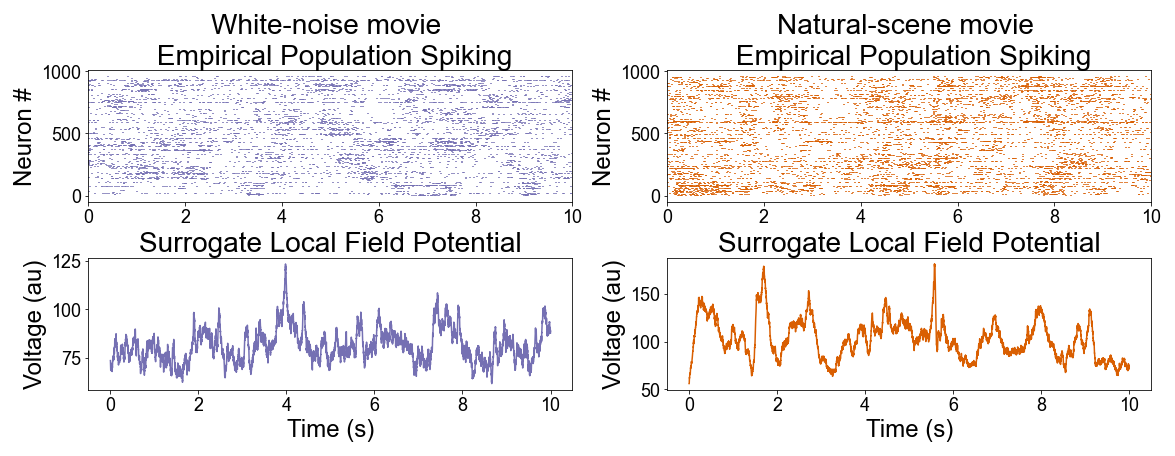

In [13]:
# plot surrogate LFPs and associated empirical spiking

# settings
time2plot = 10 # plot <time2plot> seconds only

# create figure and axes
fig = plt.figure(figsize=[16,6])

# set up gridspec
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
ax00 = fig.add_subplot(spec[0,0])
ax10 = fig.add_subplot(spec[1,0])
ax01 = fig.add_subplot(spec[0,1])
ax11 = fig.add_subplot(spec[1,1])

# plot spiking
ax00.eventplot(spike_times_noise_plt, color=COLORS[0])
ax01.eventplot(spike_times_natural_plt, color=COLORS[2])
for ax in[ax00, ax01]:
    ax.set_xlim([0, time2plot])
    
# plot LFPs
t_lfp = create_times(time2plot, FS)
ax10.plot(t_lfp, lfp_noise[:time2plot*FS], color=COLORS[0])
ax11.plot(t_lfp, lfp_natural[:time2plot*FS], color=COLORS[2])

# labels
for ax in[ax10, ax11]:
    ax.set(xlabel='Time (s)')
    ax.set(ylabel='Voltage (au)')
for ax in[ax00, ax01]:
    ax.set(ylabel='Neuron #')

# set titles
ax00.set_title('White-noise movie \n Empirical Population Spiking')
ax10.set_title('Surrogate Local Field Potential')
ax01.set_title('Natural-scene movie \n Empirical Population Spiking')
ax11.set_title('Surrogate Local Field Potential')

# save
plt.savefig(DIR_FIG + f'/panel_4_fig2.png', dpi=300)

#### plot simulation results

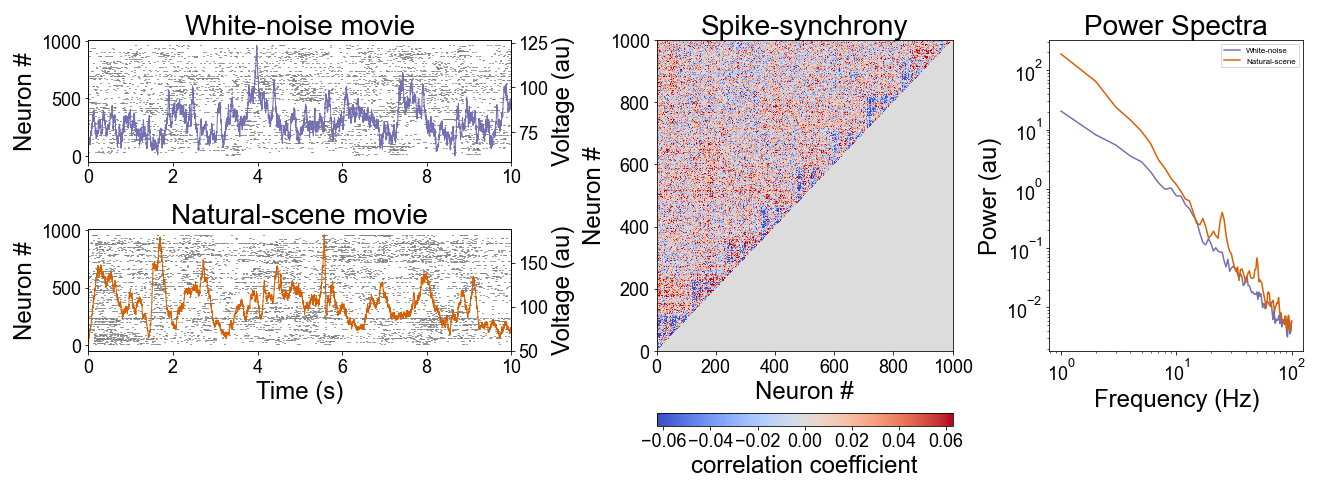

In [14]:
# create figure

# settings
time2plot = 10 # plot <time2plot> seconds only

# create figure and axes
fig = plt.figure(figsize=[18,6.5])

# set up gridspec
spec = gridspec.GridSpec(ncols=3, nrows=3, figure=fig, 
    width_ratios=[2,1.4,1.2], height_ratios=[1,1,0.1])
ax00 = fig.add_subplot(spec[0,0])
ax01 = fig.add_subplot(spec[1,0])
ax_corr = fig.add_subplot(spec[:2,1])
ax_psd = fig.add_subplot(spec[:2,2])
ax_cb = fig.add_subplot(spec[2,1])

# plot spikes and lfp
cols= [COLORS[0], COLORS[2]]
for ii, (ax, pop_spikes, field) in enumerate(zip([ax00,ax01], 
                                                 [spike_times_noise_plt, spike_times_natural_plt], 
                                                 [lfp_noise, lfp_natural])):
    # plot spikes
    ax.eventplot(pop_spikes, color='grey')
    ax.set(ylabel='Neuron #')
    ax.set_xlim([0,time2plot])
    # plot LFP
    field = field[:time2plot*FS]
    axr = ax.twinx() 
    axr.plot(time[:len(field)], field, linewidth=1, color=cols[ii])
    axr.set(ylabel='Voltage (au)')
ax01.set(xlabel='Time (s)')
ax00.sharey(ax01)

# plot corr
ax_corr.pcolormesh(corr_mat_comb, cmap='coolwarm', norm=norm)
fig.colorbar(ScalarMappable(norm=norm, cmap='coolwarm'), ax=ax_corr, cax=ax_cb,
    orientation='horizontal', label='correlation coefficient')
ax_corr.set(xlabel='Neuron #',ylabel='Neuron #')
# ax_corr.set_title('Upper: White-noise \nLower: Natural-scene')
ax_corr.set_title('Spike-synchrony')

# plt PDSs
ax_psd.loglog(freq_noise, spectra_noise, label='White-noise', color=COLORS[0])
ax_psd.loglog(freq_natural, spectra_natural, label='Natural-scene', color=COLORS[2])
ax_psd.legend(fontsize=8)

# labels
ax_psd.set(xlabel='Frequency (Hz)', ylabel='Power (au)')
for ax in[ax10, ax11]:
    ax.set(xlabel='Time (s)')
for ax in[ax00, ax01]:
    ax.set(ylabel='Neuron #')

# set titles
ax00.set_title('White-noise movie')
ax01.set_title('Natural-scene movie')
ax_psd.set_title('Power Spectra')

# save
plt.savefig(DIR_FIG + f'/panel_4_fig3.png', dpi=300)

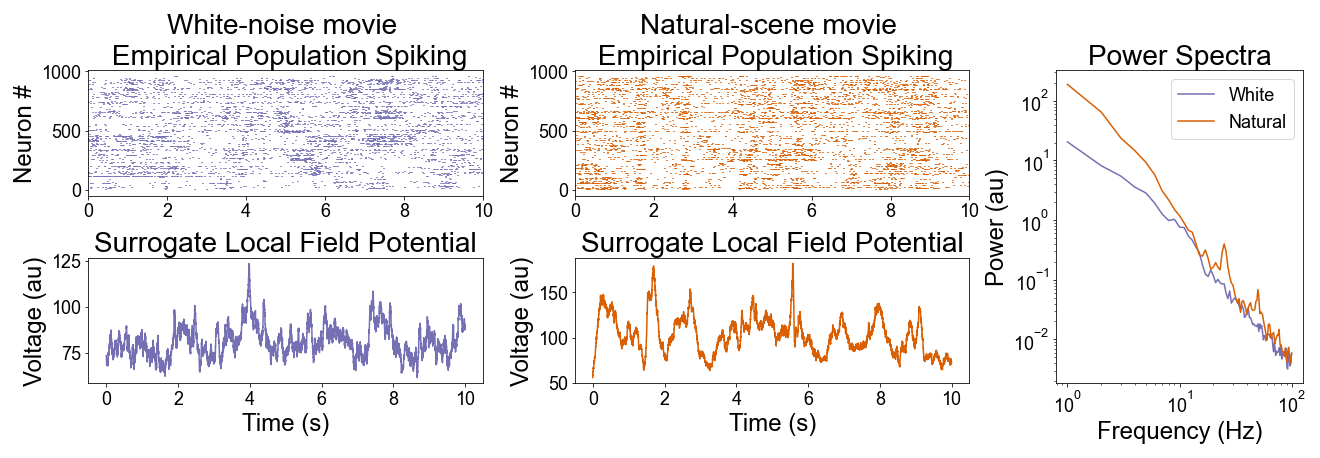

In [17]:
# plot surrogate LFPs and associated empirical spiking

# settings
time2plot = 10 # plot <time2plot> seconds only

# create figure and axes
fig = plt.figure(figsize=[18,6])

# set up gridspec
spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig, width_ratios=[1.6,1.6,1])
ax00 = fig.add_subplot(spec[0,0])
ax10 = fig.add_subplot(spec[1,0])
ax01 = fig.add_subplot(spec[0,1])
ax11 = fig.add_subplot(spec[1,1])
ax_psd = fig.add_subplot(spec[:,2])

# plot spiking
ax00.eventplot(spike_times_noise_plt, color=COLORS[0])
ax01.eventplot(spike_times_natural_plt, color=COLORS[2])
for ax in[ax00, ax01]:
    ax.set_xlim([0, time2plot])
    
# plot LFPs
t_lfp = create_times(time2plot, FS)
ax10.plot(t_lfp, lfp_noise[:time2plot*FS], color=COLORS[0])
ax11.plot(t_lfp, lfp_natural[:time2plot*FS], color=COLORS[2])

# plt PDSs
ax_psd.loglog(freq_noise, spectra_noise, label='White', color=COLORS[0])
ax_psd.loglog(freq_natural, spectra_natural, label='Natural', color=COLORS[2])
ax_psd.legend()

# labels
for ax in[ax10, ax11]:
    ax.set(xlabel='Time (s)')
    ax.set(ylabel='Voltage (au)')
for ax in[ax00, ax01]:
    ax.set(ylabel='Neuron #')
ax_psd.set(xlabel='Frequency (Hz)', ylabel='Power (au)')

# set titles
ax00.set_title('White-noise movie \n Empirical Population Spiking')
ax10.set_title('Surrogate Local Field Potential')
ax01.set_title('Natural-scene movie \n Empirical Population Spiking')
ax11.set_title('Surrogate Local Field Potential')
ax_psd.set_title('Power Spectra')

# save
plt.savefig(DIR_FIG + f'/panel_4_fig4.png')